# Capstone Project - The Battle of Neighborhoods

In [1]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In this project we try to cluster the neighbourhoods in Budapest, considering the number of existing office buildings, university buildings and cafés, and with the help of this clustering provide a suggestion to the spot that is suitable for a new office.

## Load neighborhood data of Budapest

In this section we load the required static data of the neighbourhoods of Budapest from a Hungarian Wikipedia page.

In [2]:
# Import required packages to this section
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [3]:
# Using BeautifulSoup to retrieve the districts and neighborhoods of Budapest
wikiurl="https://hu.wikipedia.org/wiki/Budapest_városrészeinek_listája"
response=requests.get(wikiurl)
soup = BeautifulSoup(response.text)
table=soup.findAll('table')

In [4]:
# We transform this data into a python array
table_contents=[]
for ind,row in enumerate(table[1].findAll('tr')):
  if ind>0:
    cells = row.findAll('td')
    district = cells[2].text.replace("\n", "")
    neighborhood = cells[1].text.replace("\n", "")
    table_contents.append({"district": district, "neighborhood": neighborhood})

In [5]:
# We load the data into a pandas dataframe
df=pd.DataFrame(table_contents)
df.head()

,district,neighborhood
0,Budapest II. kerülete,Adyliget
1,Budapest XVII. kerülete,Akadémiaújtelep
2,Budapest XI. kerülete,Albertfalva
3,Budapest XVIII. kerülete,Almáskert
4,Budapest XIV. kerülete,Alsórákos


In [6]:
# Some of the neighborhoods correspond to more districts
df[df["district"].str.contains("és", regex=False)]

,district,neighborhood
17,Budapest II. és XII. kerülete,Budakeszierdő
56,Budapest I. és XI. kerülete,Gellérthegy
94,Budapest I. és XII. kerülete,Krisztinaváros
125,Budapest IV. és XIII. kerülete,Népsziget
164,Budapest XI. és XII. kerülete,Sashegy
189,Budapest II. és III. kerülete,Újlak
199,Budapest I. és II. kerülete,Víziváros


In [7]:
# We clean data to get unique district-neighborhood pairs
df_bp=pd.DataFrame(columns=["district", "neighborhood"])

roman = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X",
         "XI", "XII", "XIII", "XIV", "XV", "XVI", "XVII", "XVIII", "XIX", "XX",
         "XXI", "XXII", "XXIII"]

for n in roman:
  df_temp = df[df["district"].str.contains(" " + n + ".", regex=False)].copy()
  df_temp["district"] = [n]*df_temp.shape[0]
  df_bp = df_bp.append(df_temp, ignore_index=True)

df_bp.head()

,district,neighborhood
0,I,Gellérthegy
1,I,Krisztinaváros
2,I,Tabán
3,I,Vár
4,I,Víziváros


## Geometry of the neghborhoods

In this section we collect the required location data about the neighbourhoods and visualize them on the map.

In [8]:
# Import required packages
from geopy.geocoders import Nominatim, Photon
import os
import folium

In [9]:
# Data is saved to a file. If this file does not exists, an API go through the
# neighborhoods and find the latitude and longitude coordinates of each
if os.path.exists("bp_neigh_data.csv"):
  df_bp = pd.read_csv("bp_neigh_data.csv", index_col=0)
else:
  geolocator = Photon(user_agent='budapest-locator')

  latitude = []
  longitude = []

  for n,d in zip(df_bp["neighborhood"].to_list(),df_bp["district"].to_list()):
    location = geolocator.geocode(n + ", Budapest, " + d + ". kerület", timeout=5)
    if location:
      latitude.append(location.latitude)
      longitude.append(location.longitude)
    else:
      latitude.append(np.nan)
      longitude.append(np.nan)
  df_bp["Latitude"] = latitude
  df_bp["Longitude"] = longitude
  df_bp.to_csv("bp_neigh_data.csv")

In [10]:
df_bp.head(10)

,district,neighborhood,Latitude,Longitude
0,I,Gellérthegy,47.492064,19.037200
1,I,Krisztinaváros,47.496866,19.029776
2,I,Tabán,47.491613,19.043169
3,I,Vár,47.495334,19.039546
4,I,Víziváros,47.503719,19.039128
5,II,Adyliget,47.547550,18.938984
6,II,Budakeszierdő,47.542471,18.972903
7,II,Budaliget,47.567579,18.940664
8,II,Csatárka,47.531525,19.002578
9,II,Erzsébetliget,47.561714,18.967558


In [11]:
# Get the center point of the city Budapest to initialize a map
address = 'Budapest, Hungary'
geolocator = Nominatim(user_agent="budapest_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [12]:
# Create map of Budapest
map_bp = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map that belong to the neighbourhoods
for lat, lng, district, neighborhood in zip(df_bp['Latitude'],
                                           df_bp['Longitude'],
                                           df_bp['district'],
                                           df_bp['neighborhood']):
    label = '{}, {}. kerület'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bp)

In [13]:
map_bp

## Collect venue data from the neighborhoods

In [14]:
# Set the necessary parameters to initializa an API call.
CLIENT_ID = 'NGKQMPLWGLFFYY4MSMVY22GZKQADGOTVMYQ1T5IXTTK2QJ4Z'
CLIENT_SECRET = 'NGUPRLUVFBPGNCT2G2PJVF3XNNOIQQO0UEFHOS530YSEWQEQ'
VERSION = '20180605'
LIMIT = 100

In [15]:
# We predefine some venue categories that we want to measure
# in the neighborhoods
venue_list = {"office": "4bf58dd8d48988d124941735",
              "university": "4d4b7105d754a06372d81259",
              "cafe": "4bf58dd8d48988d16d941735"}

In [16]:
# A function that returns the number of the venues predefined venues
# near a cartographical coordinate point
def get_number_of_nearby_venues(lat, long):
  row_to_result = {}
  for i,cid in enumerate(venue_list.values()):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
      CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, 300, LIMIT, cid)
    results = requests.get(url).json()["response"]
    print(results)
    row_to_result[list(venue_list.keys())[i]] = len(results["groups"][0]["items"])
  return row_to_result

In [17]:
# We create another dataframe in which we collect the nearby venues data.
# Data is stored in a csv, if this csv daoes not exist, we go through the
# neighborhoods by API calls and find the necessarry information

if os.path.exists("venue_count_data.csv"):
  df_vc = pd.read_csv("venue_count_data.csv", index_col=0)
else:
  df_vc = pd.DataFrame(columns=list(venue_list.keys()))
  for index, row in df_bp.iterrows():
    dd = get_number_of_nearby_venues(row["Latitude"], row["Longitude"])
    df_vc = df_vc.append(dd, ignore_index=True)
  df_vc.to_csv("venue_count_data.csv")

In [18]:
df_vc.head()

,office,university,cafe
0,4,3,3
1,17,5,7
2,2,1,3
3,3,4,8
4,4,3,8


In [19]:
# Join this dataframe into the neigborhoods' one
df_full = df_bp.join(df_vc)
df_full.head()

,district,neighborhood,Latitude,Longitude,office,university,cafe
0,I,Gellérthegy,47.492064,19.037200,4,3,3
1,I,Krisztinaváros,47.496866,19.029776,17,5,7
2,I,Tabán,47.491613,19.043169,2,1,3
3,I,Vár,47.495334,19.039546,3,4,8
4,I,Víziváros,47.503719,19.039128,4,3,8


In [20]:
df_full.head(10).to_latex("vvv.tex")

## Clustering

In this section we analyze the above informations via clustering methods.

In [21]:
# import required packages
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Find the appropriate K for clustering

In [22]:
# Extract the necessary data from the dataframe
x1 = df_full["office"]
x2 = df_full["university"]
x3 = df_full["cafe"]
X = np.array(list(zip(x1, x2, x3))).reshape(len(x1), 3)

In [23]:
# We initialize some variable to sweep through different values of K
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2,20)

In [24]:
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_full[["office",
                                                               "university",
                                                               "cafe"]])
    # Update variables
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[k] = sum(np.min(cdist(X, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeans.inertia_

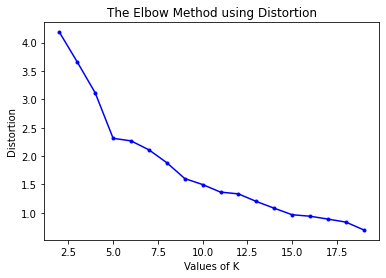

In [25]:
# We plot the distortion for different values of K
plt.plot(K, distortions, 'b.-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.savefig("kmeans.pdf")

Because of the elbow rule, we use 5 clusters in the later sections.

### Clustering the neighbourhoods

In [26]:
# Set number of clusters
kclusters = 5
# Clustering the coordinates of the neighborhoods
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_full[["office", "university", "cafe"]])
# Add cluster labels to the orifginal data
df_bp_merged = df_full.copy()
df_bp_merged.insert(0, 'Cluster Labels', kmeans.labels_)
df_bp_merged.head()

,Cluster Labels,district,neighborhood,Latitude,Longitude,office,university,cafe
0,0,I,Gellérthegy,47.492064,19.037200,4,3,3
1,1,I,Krisztinaváros,47.496866,19.029776,17,5,7
2,3,I,Tabán,47.491613,19.043169,2,1,3
3,0,I,Vár,47.495334,19.039546,3,4,8
4,0,I,Víziváros,47.503719,19.039128,4,3,8


In [27]:
# Create map of Budapest
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gnuplot2(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_bp_merged['Latitude'], df_bp_merged['Longitude'], df_bp_merged['neighborhood'], df_bp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
df_bp_merged[["Cluster Labels", "office", "university", "cafe"]].groupby(by=["Cluster Labels"]).size()

Cluster Labels
0     29
1      9
2      3
3    164
4      4
dtype: int64

### Discussion of the clustering

For each cluster, we investigate the frequency of the offices, universities and cafés.

In [29]:
df0 = df_bp_merged.loc[df_bp_merged['Cluster Labels'] == 0]
df1 = df_bp_merged.loc[df_bp_merged['Cluster Labels'] == 1]
df2 = df_bp_merged.loc[df_bp_merged['Cluster Labels'] == 2]
df3 = df_bp_merged.loc[df_bp_merged['Cluster Labels'] == 3]
df4 = df_bp_merged.loc[df_bp_merged['Cluster Labels'] == 4]

In [30]:
df0.head(10)

,Cluster Labels,district,neighborhood,Latitude,Longitude,office,university,cafe
0,0,I,Gellérthegy,47.492064,19.037200,4,3,3
3,0,I,Vár,47.495334,19.039546,3,4,8
4,0,I,Víziváros,47.503719,19.039128,4,3,8
28,0,II,Rózsadomb,47.517329,19.028288,8,2,0
31,0,II,Szépilona,47.519217,18.990449,1,17,0
35,0,II,Vérhalom,47.523980,19.015493,5,2,1
36,0,II,Víziváros,47.503719,19.039128,4,3,8
62,0,VII,Erzsébetváros,47.502814,19.077359,3,13,4
64,0,VIII,Csarnoknegyed,47.488789,19.086434,2,8,0
65,0,VIII,Ganznegyed,47.488789,19.086434,2,8,0


In [31]:
df1.head(10)

,Cluster Labels,district,neighborhood,Latitude,Longitude,office,university,cafe
1,1,I,Krisztinaváros,47.496866,19.029776,17,5,7
21,1,II,Országút,47.511709,19.027287,18,3,11
61,1,VI,Terézváros,47.503250,19.064396,24,10,23
63,1,VIII,Corvin-negyed,47.487069,19.074314,31,2,11
74,1,IX,Belső-Ferencváros,47.489137,19.061715,21,25,15
117,1,XII,Krisztinaváros,47.499479,19.024876,16,4,2
121,1,XII,Németvölgy,47.489525,19.017843,15,5,2
130,1,XIII,Újlipótváros,47.536473,19.074019,19,3,0
131,1,XIII,Vizafogó,47.538881,19.069458,30,4,2


In [32]:
df2.head(10)

,Cluster Labels,district,neighborhood,Latitude,Longitude,office,university,cafe
71,2,VIII,Palotanegyed,47.492185,19.066103,6,49,13
94,2,XI,Infopark,47.470484,19.060338,33,49,2
99,2,XI,Lágymányos,47.478441,19.057715,4,61,1


In [33]:
df3.head(10)

,Cluster Labels,district,neighborhood,Latitude,Longitude,office,university,cafe
2,3,I,Tabán,47.491613,19.043169,2,1,3
5,3,II,Adyliget,47.547550,18.938984,0,0,0
6,3,II,Budakeszierdő,47.542471,18.972903,0,0,0
7,3,II,Budaliget,47.567579,18.940664,0,1,0
8,3,II,Csatárka,47.531525,19.002578,0,1,0
9,3,II,Erzsébetliget,47.561714,18.967558,0,0,0
10,3,II,Erzsébettelek,47.544978,18.957372,1,0,0
11,3,II,Felhévíz,47.518132,19.035933,1,3,3
12,3,II,Gercse,47.567464,18.985744,0,0,0
13,3,II,Hársakalja,47.551378,18.966541,0,0,0


In [34]:
df4.head(10)

,Cluster Labels,district,neighborhood,Latitude,Longitude,office,university,cafe
34,4,II,Újlak,47.528855,19.037298,57,2,9
52,4,III,Újlak,47.528855,19.037298,57,2,9
59,4,V,Belváros,47.500336,19.048971,46,15,16
60,4,V,Lipótváros,47.500336,19.048971,46,15,16


In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,6))
fig.suptitle('Frequencies of ...', fontsize=16)

df1['university'].value_counts().plot(kind='bar',
                                      title='universities',
                                      ax=axes[0])
df1['cafe'].value_counts().plot(kind='bar',
                                      title='cafés',
                                      ax=axes[1])
df1['office'].value_counts().plot(kind='bar',
                                      title='offices',
                                      ax=axes[2])
fig.supylabel('Frequency')
fig.supxlabel('Number')
plt.savefig("df1.pdf")
plt.close()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<Figure size 648x432 with 0 Axes>

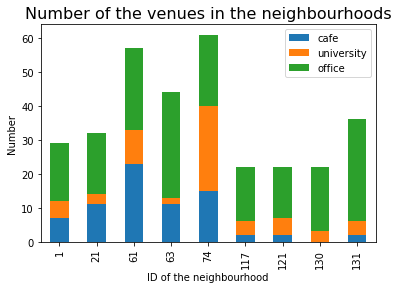

In [36]:
plt.figure(figsize=(9, 6))
df1[['cafe','university','office']].plot(kind='bar', stacked=True)
plt.xlabel('ID of the neighbourhood')
plt.ylabel('Number')
plt.title('Number of the venues in the neighbourhoods', fontsize=16)
plt.show()
plt.close()